<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/5_Q1_Set1_preprocessing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook, the lexeme strings and word features derived in the previous notebook are used as a feature set.

The processing pipeline is outlined in the image below:
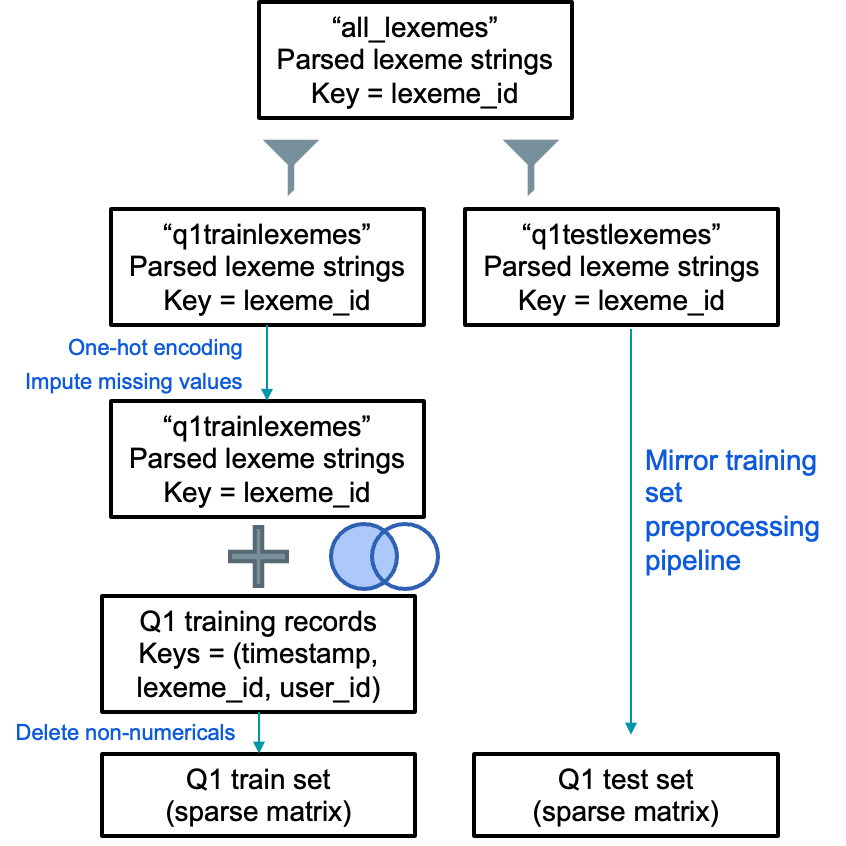

The same preprocessing pipeline will be used to transform the Q1test set. 

This will make both datasets ready for modeling. 

Since larger dimensions are being dealt with, high-RAM option is selected:

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



## <font color='cornflowerblue' size=4>Loading data</font>


Importing libraries and mounting google drive:


In [2]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Loading Q1 train set:

In [3]:
q1train = decompress_pickle(path_name+"Q1TRAIN.pbz2") 

In [4]:
q1train.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
7,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:07:12,5.143600,1.000000
15,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:08:50,0.000891,1.000000
20,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,18.921030,0.888889
21,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,0.714286
22,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,0,0.000159,"(en, es)",2013-02-28 20:11:14,19.776609,1.000000


Loading Q1 test set:

In [5]:
q1test = decompress_pickle(path_name+"Q1TEST.pbz2")

In [6]:
q1test.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
23,1362082274,444649,u:dDwF,es,en,4bdb859f599fa07dd5eecdab0acc2d34,a/a<pr>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,5.146400,1.000000
26,1362082274,678813,u:dDwF,es,en,64f2b1bdc5c91bb3f6ca1bb7a808b60a,quieres/querer<vblex><pri><p2><sg>,3,3,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,7.856632,1.000000
30,1362082274,8562343,u:dDwF,es,en,edf5a0ef6c836c4df4f3b3de76ca63ba,diario/diario<n><m><sg>,3,3,3,3,0,0.000159,"(en, es)",2013-02-28 20:11:14,99.101192,1.000000
41,1362082274,6645723,u:dDwF,es,en,c2c8a202a12411858f87d4dcef5b2998,no/no<adv>,5,5,1,1,0,0.000159,"(en, es)",2013-02-28 20:11:14,76.918090,1.000000
50,1362082274,7239420,u:dDwF,es,en,81fe07635e2aa79cd36709cf1bdd81be,limón/limón<n><m><sg>,3,2,2,2,0,0.000159,"(en, es)",2013-02-28 20:11:14,83.789583,0.666667


Confirming the shapes:

In [7]:
q1train.shape, q1test.shape

((8070561, 17), (1795528, 17))

In [8]:
q1train.size/10**6, q1test.size/10**6

(137.199537, 30.523976)

List of lexeme ids in q1train dataframe:

In [9]:
q1train_lexemelist = q1train['lexeme_id'].unique()

In [10]:
all_lexemes = decompress_pickle(path_name+"Duolingo_all_lexemes.pbz2")

In [11]:
all_lexemes.shape

(19279, 17)

Filtering to only the words in the training set 

In [12]:
q1trainlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1train_lexemelist),:]

In [13]:
q1trainlexemes.columns, q1trainlexemes.shape

(Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
        'lemma_form', 'pos', 'modstrings', 'sf_length', 'sf_translation',
        'lf_translation', 'surface_form_no_accents', 'lemma_form_no_accents',
        'L_dist_word_tup_sf_noaccents', 'L_dist_sf_noaccents',
        'L_dist_sf_noaccents_norm', 'IDFword', 'EnglishIDF'],
       dtype='object'), (12446, 17))

Filtering out test set lexemes dataframe for transformation:

In [14]:
q1test_lexemelist = q1test['lexeme_id'].unique()
q1testlexemes = all_lexemes.loc[all_lexemes['lexeme_id'].isin(q1test_lexemelist),:]

In [15]:
q1testlexemes.shape

(2776, 17)

## <font color = 'cornflowerblue' size=4>Preprocessing:</font>

### <font color = 'cornflowerblue' size=3>One hot encoding of categoricals</font>
The learning language, pos and mostrings are further converted to binary dummies: 

In [16]:
from sklearn.preprocessing import OneHotEncoder

enc_lang = OneHotEncoder(sparse=False,handle_unknown='ignore')
enc_pos = OneHotEncoder(sparse = False,handle_unknown = 'ignore')
enc_mods = OneHotEncoder(sparse=False,handle_unknown='ignore')

# get one hot encoded learning language
enc_lang.fit(np.array(q1trainlexemes['learning_language']).reshape(-1, 1))
q1train_lang = pd.DataFrame(enc_lang.transform(np.array(q1trainlexemes['learning_language']).reshape(-1, 1)),index=q1trainlexemes.index)

# get one hot encoded part of speech:
enc_pos.fit(np.array(q1trainlexemes['pos']).reshape(-1, 1))
q1train_pos = pd.DataFrame(enc_pos.transform(np.array(q1trainlexemes['pos']).reshape(-1, 1)),index=q1trainlexemes.index)


In [17]:
# get one hot encoded modstrings
q1trainlexemes['modstrings'].head()

7                []
20          [m, pl]
21    [pri, p1, sg]
22          [m, sg]
24    [pri, p3, sg]
Name: modstrings, dtype: object

Since modstrings are saved as a list of strings, some more processing needs to be done before passing to the one hot encoder. 

In [18]:
# explode values of list so a separate record is created for each element of the list. 
q1trainlexemes['modstrings'].explode()
enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1train_mods_exploded =enc_mods.transform(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))

q1train_modsdf_exploded = pd.DataFrame(q1train_mods_exploded, index = q1trainlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1train_modsdf = q1train_modsdf_exploded.groupby(q1train_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [19]:
q1train_modsdf.shape, q1trainlexemes.shape

((12446, 86), (12446, 17))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [20]:
q1trainfeatureset1 = pd.concat([q1trainlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']],
                                q1train_lang, 
                                q1train_pos, 
                                q1train_modsdf, 
                                ],axis=1)

In [21]:
q1trainfeatureset1.shape

(12446, 167)

In [22]:
q1trainfeatureset1.columns = ['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id'] + ['lang_'+c for c in list(enc_lang.get_feature_names_out())] + ['pos_' + c for c in list(enc_pos.get_feature_names_out())] + ['mod_' + c for c in list(enc_mods.get_feature_names_out())]

In [23]:
len(list(q1trainfeatureset1.columns)) - len(set(q1trainfeatureset1.columns))

0

In [24]:
q1trainfeatureset1.head()

,sf_length,L_dist_sf_noaccents_norm,EnglishIDF,lexeme_id,lang_x0_en,lang_x0_es,lang_x0_fr,lang_x0_it,lang_x0_pt,pos_x0_@adv:a_part,...,mod_x0_prs,mod_x0_qnt,mod_x0_ref,mod_x0_sg,mod_x0_sint,mod_x0_sp,mod_x0_subj,mod_x0_sup,mod_x0_tn,mod_x0_nan
7,4,0.5,3.733996,73eecb492ca758ddab5371cf7b5cca32,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20,5,0.6,10.981924,c84476c460737d9fb905dca3d35ec995,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,3,0.0,4.051187,1a913f2ded424985b9c02d0436008511,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,5,0.8,0.438409,38b770e66595fea718366523b4f7db3f,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24,3,1.0,0.502649,faa6fd18132b358958e440322ee82b4b,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The feature set has 167 columns. 

Applying the same transformations to the test set lexemes:

In [25]:
# transforming the language column based on already fit one hot encoder:
q1test_lang = pd.DataFrame(enc_lang.transform(np.array(q1testlexemes['learning_language']).reshape(-1, 1)),index=q1testlexemes.index)

# get one hot encoded part of speech:
q1test_pos = pd.DataFrame(enc_pos.transform(np.array(q1testlexemes['pos']).reshape(-1, 1)),index=q1testlexemes.index)


In [26]:
# explode values of list so a separate record is created for each element of the list. 
q1testlexemes['modstrings'].explode()
#enc_mods.fit(np.array(q1trainlexemes['modstrings'].explode()).reshape(-1,1))
q1test_mods_exploded =enc_mods.transform(np.array(q1testlexemes['modstrings'].explode()).reshape(-1,1))

q1test_modsdf_exploded = pd.DataFrame(q1test_mods_exploded, index = q1testlexemes['modstrings'].explode().index)

# group the exploded one-hot dataframe by the q1lexemes index, sum up the exploded records (since one word can have many modifiers in its list)
q1test_modsdf = q1test_modsdf_exploded.groupby(q1test_modsdf_exploded.index).sum()
#np.concatenate([np.array(q1trainlexemes['modstrings'].explode().index).reshape(-1,1),q1train_mods],axis=1)

In [27]:
q1test_modsdf.shape, q1testlexemes.shape

((2776, 86), (2776, 17))

The summed shape of the mods dataframe is the same length as the q1trainlexemes dataframe. 

Now the language, pos and mod sparse columns are combined along with numerical word features to make the first feature set. 

In [28]:
q1testfeatureset1 = pd.concat([q1testlexemes[['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF','lexeme_id']],
                                q1test_lang, 
                                q1test_pos, 
                                q1test_modsdf, 
                                ],axis=1)

In [29]:
q1testfeatureset1.shape

(2776, 167)

In [30]:
q1testfeatureset1.columns = q1trainfeatureset1.columns

The number of dimensions matches for train and test post binarizing categorical columns. They are saved as compressed pickle files. 

In [31]:
compressed_pickle(path_name+"Q1TRAIN_lexemesFS1",q1trainfeatureset1)
compressed_pickle(path_name+"Q1TEST_lexemesFS1",q1testfeatureset1)

## <font color = 'cornflowerblue' size=4>Joining lexemes data with main train and test dataframes</font>

 Estimate of total size of dataset once joined. 

In [33]:
(q1trainfeatureset1.size/10**6)/q1trainfeatureset1.shape[0]*q1train.shape[0] + q1train.size/10**6

1484.983224

The estimated size of a full combined feature set without any dimension reduction is 1.4GB. 

Attempts to combine it all at once failed even with high RAM.

```
# getting lexeme id for the full feature set 1
q1trainfeatureset1['lexeme_id'] = q1trainlexemes.loc[q1trainfeatureset1.index,'lexeme_id']

# joining with main dataframe on lexeme id
q1train_withfs1 = pd.merge(left= q1train,right=q1train,left_on='lexeme_id',right_on = 'lexeme_id',how="left")
```

As a workaround, the following process is used.

1.  100,000 rows of the main dataframe are taken at a time,joined with q1trainfeatureset1, 
2. and then compressed to a sparse matrix. 
3. The sparse matrices generated are stacked vertically to build a compressed sprarse version of the full dataset. 

Droping extraneous columns from q1train, and q1trainfeatureset1

In [34]:
q1train.columns

Index(['timestamp', 'delta', 'user_id', 'learning_language', 'ui_language',
       'lexeme_id', 'lexeme_string', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'p_forgot_bin', 'simoverdiff',
       'lang_frozenset', 'Datetime', 'delta_days', 'history_frac'],
      dtype='object')

The columns needed for merging with lexemes for q1train_X: delta, lexeme_id, history_seen, history_frac, simoverdiff, 

The columns needed for q1train_y: p_forgot_bin


In [35]:
q1train_X = q1train[['lexeme_id','delta','history_seen','history_frac','simoverdiff']]

q1train_y = q1train['p_forgot_bin']

In [36]:
q1train_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')

In [37]:
q1train_X.isna().sum()

lexeme_id       0
delta           0
history_seen    0
history_frac    0
simoverdiff     0
dtype: int64

With the exception of lexeme id (needed for joining) all other non-numerical columns have been dropped. 

In [38]:
q1trainfeatureset1.columns[0:5]

Index(['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF', 'lexeme_id',
       'lang_x0_en'],
      dtype='object')

In [39]:
q1trainfeatureset1.isna().sum()

sf_length                     0
L_dist_sf_noaccents_norm      0
EnglishIDF                  267
lexeme_id                     0
lang_x0_en                    0
                           ... 
mod_x0_sp                     0
mod_x0_subj                   0
mod_x0_sup                    0
mod_x0_tn                     0
mod_x0_nan                    0
Length: 167, dtype: int64

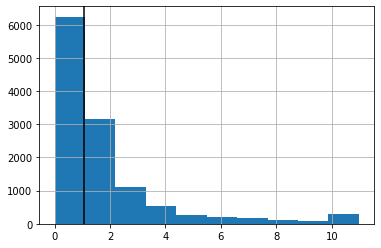

In [40]:
q1trainfeatureset1['EnglishIDF'].hist()
plt.axvline(q1trainfeatureset1['EnglishIDF'].median(),color='black')

Imputing:

In [41]:
q1trainfeatureset1.loc[q1trainfeatureset1['EnglishIDF'].isna(),'EnglishIDF'] = q1trainfeatureset1['EnglishIDF'].median()

In [42]:
q1trainfeatureset1.isna().sum().sum()

0

No missing values left. 

## <font color = 'cornflowerblue' size=4>Conversion to sparse matrix and saving:</font>

In [43]:
try: 
  del Xq1
except:
  pass

In [44]:
from scipy.sparse import coo_matrix, vstack
count = 0
for i in range(0,q1train_X.shape[0],100000):
  if count%2:
    print(count)
  
  subdata = q1train_X.iloc[i:min(i+100000,q1train_X.shape[0]),:]
  subdata = pd.merge(left = subdata, right = q1trainfeatureset1,left_on = 'lexeme_id',right_on = 'lexeme_id',how="left")
  subdata = subdata.drop('lexeme_id',axis=1)
  #print('size: ',subdata.size/10**6)

  mat = coo_matrix(subdata)
  #print('size after compression: ',mat.size/10**6)
  if i >1:
    print('stacking: ')
    Xq1 = vstack([Xq1,mat])
    #print('saving: ',"Xq1_"+str(count))
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  else:
    Xq1 = mat
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  del subdata, mat
  count +=1
#print('Saved all, size Xq1: ',Xq1.size/10**6)
compressed_pickle(path_name+"q1train_pipe1", Xq1)

1
stacking: 
stacking: 
3
stacking: 
stacking: 
5
stacking: 
stacking: 
7
stacking: 
stacking: 
9
stacking: 
stacking: 
11
stacking: 
stacking: 
13
stacking: 
stacking: 
15
stacking: 
stacking: 
17
stacking: 
stacking: 
19
stacking: 
stacking: 
21
stacking: 
stacking: 
23
stacking: 
stacking: 
25
stacking: 
stacking: 
27
stacking: 
stacking: 
29
stacking: 
stacking: 
31
stacking: 
stacking: 
33
stacking: 
stacking: 
35
stacking: 
stacking: 
37
stacking: 
stacking: 
39
stacking: 
stacking: 
41
stacking: 
stacking: 
43
stacking: 
stacking: 
45
stacking: 
stacking: 
47
stacking: 
stacking: 
49
stacking: 
stacking: 
51
stacking: 
stacking: 
53
stacking: 
stacking: 
55
stacking: 
stacking: 
57
stacking: 
stacking: 
59
stacking: 
stacking: 
61
stacking: 
stacking: 
63
stacking: 
stacking: 
65
stacking: 
stacking: 
67
stacking: 
stacking: 
69
stacking: 
stacking: 
71
stacking: 
stacking: 
73
stacking: 
stacking: 
75
stacking: 
stacking: 
77
stacking: 
stacking: 
79
stacking: 
stacking: 


In [45]:
Xq1.size/10**6

86.851987

The compressed matrix X is 86.85 MB.

Saving q1train_y:

In [46]:
compressed_pickle(path_name+"q1train_y",q1train_y)

In [47]:
q1test_X = q1test[['lexeme_id','delta','history_seen','history_frac','simoverdiff']]

q1test_y = q1test['p_forgot_bin']

In [48]:
q1test_X.columns

Index(['lexeme_id', 'delta', 'history_seen', 'history_frac', 'simoverdiff'], dtype='object')

With the exception of lexeme id (needed for joining) all other non-numerical columns have been dropped. 

In [49]:
q1testfeatureset1.columns[0:5]

Index(['sf_length', 'L_dist_sf_noaccents_norm', 'EnglishIDF', 'lexeme_id',
       'lang_x0_en'],
      dtype='object')

In [50]:
q1testfeatureset1.isna().sum()

sf_length                    0
L_dist_sf_noaccents_norm     0
EnglishIDF                  55
lexeme_id                    0
lang_x0_en                   0
                            ..
mod_x0_sp                    0
mod_x0_subj                  0
mod_x0_sup                   0
mod_x0_tn                    0
mod_x0_nan                   0
Length: 167, dtype: int64

Imputing missing values in test set with the median of the **train set values**

In [51]:
q1testfeatureset1.loc[q1testfeatureset1['EnglishIDF'].isna(),'EnglishIDF'] = q1trainfeatureset1['EnglishIDF'].median()

In [52]:
q1testfeatureset1.isna().sum().sum()

0

In [53]:
try: 
  del Xq1
except:
  pass

In [54]:
count = 0
for i in range(0,q1test_X.shape[0],100000):
  if count%2:
    print(count)
  
  subdata = q1test_X.iloc[i:min(i+100000,q1test_X.shape[0]),:]
  subdata = pd.merge(left = subdata, right = q1testfeatureset1,left_on = 'lexeme_id',right_on = 'lexeme_id',how="left")
  subdata = subdata.drop('lexeme_id',axis=1)
  #print('size: ',subdata.size/10**6)

  mat = coo_matrix(subdata)
  #print('size after compression: ',mat.size/10**6)
  if i >1:
    print('stacking: ')
    Xq1 = vstack([Xq1,mat])
    #print('saving: ',"Xq1_"+str(count))
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  else:
    Xq1 = mat
    #compressed_pickle(path_name+"Xq1_"+str(count), mat)
  del subdata, mat
  count +=1
#print('Saved all, size Xq1: ',Xq1.size/10**6)
compressed_pickle(path_name+"q1test_pipe1", Xq1)

1
stacking: 
stacking: 
3
stacking: 
stacking: 
5
stacking: 
stacking: 
7
stacking: 
stacking: 
9
stacking: 
stacking: 
11
stacking: 
stacking: 
13
stacking: 
stacking: 
15
stacking: 
stacking: 
17
stacking: 


In [55]:
compressed_pickle(path_name+"q1test_y",q1test_y)

In [56]:
enc_lang.get_feature_names_out()

array(['x0_en', 'x0_es', 'x0_fr', 'x0_it', 'x0_pt'], dtype=object)

In [57]:
enc_pos.get_feature_names_out()

array(['x0_@adv:a_part', 'x0_@adv:a_peu_pres', 'x0_@adv:a_posteriori',
       'x0_@adv:a_priori', 'x0_@adv:au_dela', 'x0_@adv:au_moins',
       'x0_@adv:en_general', 'x0_@adv:peut_etre', 'x0_@adv:por_favor',
       'x0_@adv:por_supuesto', 'x0_@adv:s_il_te_plait',
       'x0_@adv:s_il_vous_plait', 'x0_@adv:tout_a_fait',
       'x0_@cnj:alors_que', 'x0_@cnj:apres_que', 'x0_@cnj:autant_que',
       'x0_@cnj:avant_que', 'x0_@cnj:bien_que', 'x0_@cnj:depuis_que',
       'x0_@cnj:des_que', 'x0_@cnj:du_fait_que', 'x0_@cnj:parce_que',
       'x0_@cnj:pendant_que', 'x0_@cnj:tandis_que',
       'x0_@common_phrases:a_bientot', 'x0_@common_phrases:a_demain',
       'x0_@common_phrases:a_plus', 'x0_@common_phrases:a_plus_tard',
       'x0_@common_phrases:ca_va_bien',
       'x0_@common_phrases:comment_ca_va', 'x0_@common_phrases:de_rien',
       'x0_@common_phrases:il_y_a', 'x0_@ij:au_revoir',
       'x0_@ij:buenas_noches', 'x0_@ij:buenos_dias',
       'x0_@ij:merci_beaucoup', 'x0_@itg:est_ce_que',


In [58]:
enc_mods.get_feature_names_out()

array(['x0_*gndr', 'x0_*numb', 'x0_*pers', 'x0_@compound_past',
       'x0_@cond_perfect', 'x0_@det:a_le', 'x0_@det:de_le', 'x0_@formal',
       'x0_@future', 'x0_@future_perfect', 'x0_@future_phrasal',
       'x0_@ger_past', 'x0_@n:petit_ami', 'x0_@neg:il_ne_y_a', 'x0_@obj',
       'x0_@passive', 'x0_@past', 'x0_@past_cond', 'x0_@past_inf',
       'x0_@past_perfect', 'x0_@past_subjunctive', 'x0_@pluperfect',
       'x0_@pos', 'x0_@present_perfect', 'x0_@prn:ce_dont',
       'x0_@prn:celui_ci', 'x0_@prn:celui_la', 'x0_@prn:le_meme',
       'x0_@prn:le_mien', 'x0_@prn:le_notre', 'x0_@prn:quelque_chose',
       'x0_@prn:quelque_un', 'x0_@ref', 'x0_@subjunctive_perfect',
       'x0_@subjunctive_pluperfect', 'x0_aa', 'x0_adv', 'x0_an', 'x0_ant',
       'x0_cni', 'x0_comp', 'x0_def', 'x0_dem', 'x0_det', 'x0_dim',
       'x0_enc', 'x0_f', 'x0_fti', 'x0_ger', 'x0_ifi', 'x0_imp', 'x0_ind',
       'x0_inf', 'x0_itg', 'x0_loc', 'x0_m', 'x0_mf', 'x0_nn', 'x0_nt',
       'x0_obj', 'x0_ord', 'x0_p1

In [59]:
q1pipe1_column_names = ['delta', 'history_seen',
                   'history_frac', 'simoverdiff',
                      ] + list(q1trainfeatureset1.columns)

In [60]:
q1pipe1_column_names = [col for col in q1pipe1_column_names if col!='lexeme_id']

In [61]:
len(q1pipe1_column_names), Xq1.shape

(170, (1795528, 170))

Saving columns names:

In [62]:
compressed_pickle(path_name+"q1fs1_column_names",q1pipe1_column_names)

## <font color = 'cornflowerblue' size=4>Conclusions and Next Steps</font>

Word based features have been joined to the Q1 train and test dataframes, and stored as compressed sparse matrices. 

Scaling will be done before modeling. 

Next steps:

Further split q1train_featureset1 into training and validation sets (90-10) split. 

1. Model with classical machine learning techniques
- downsample or upsample or adjust class weight hyperparameter
- logistic regression
- decision tree

2. Ensemble techniques
- Random Forest
- AdaBoost
- XGBoost

3. Neural net
- Dense neural net. 

Model performance of Feature set1 will be compared with validation set performance average precision and ROC AUC.
